Current working directory: /Users/zachbovaird
Synthetic Nodes Data:
    Id      Label           src_ip          dest_ip  protocol
0    0  Anomalous    18.28.224.113      249.82.2.63  Profinet
1    1     Normal   114.41.156.135  238.141.123.196  Profibus
2    2     Normal    38.211.29.138    153.226.82.43    Modbus
3    3     Normal    91.254.100.70    36.187.66.124  Profinet
4    4     Normal    83.100.55.128     49.94.101.78    Modbus
5    5     Normal   114.173.77.125     88.109.6.238  Profinet
6    6     Normal     213.56.57.27     80.44.175.86    Modbus
7    7     Normal    93.185.115.11  151.126.199.188  Profinet
8    8     Normal   103.54.164.141    192.79.202.20  Profinet
9    9     Normal  235.114.143.137     91.129.92.87  Profibus
10  10  Anomalous   144.176.204.98   209.228.62.183  Profinet
11  11     Normal    219.110.8.244    156.122.4.242  Profinet
12  12     Normal    227.246.3.238    109.38.12.239  Profinet
13  13     Normal   193.240.30.249   207.234.124.41    Modbus
14

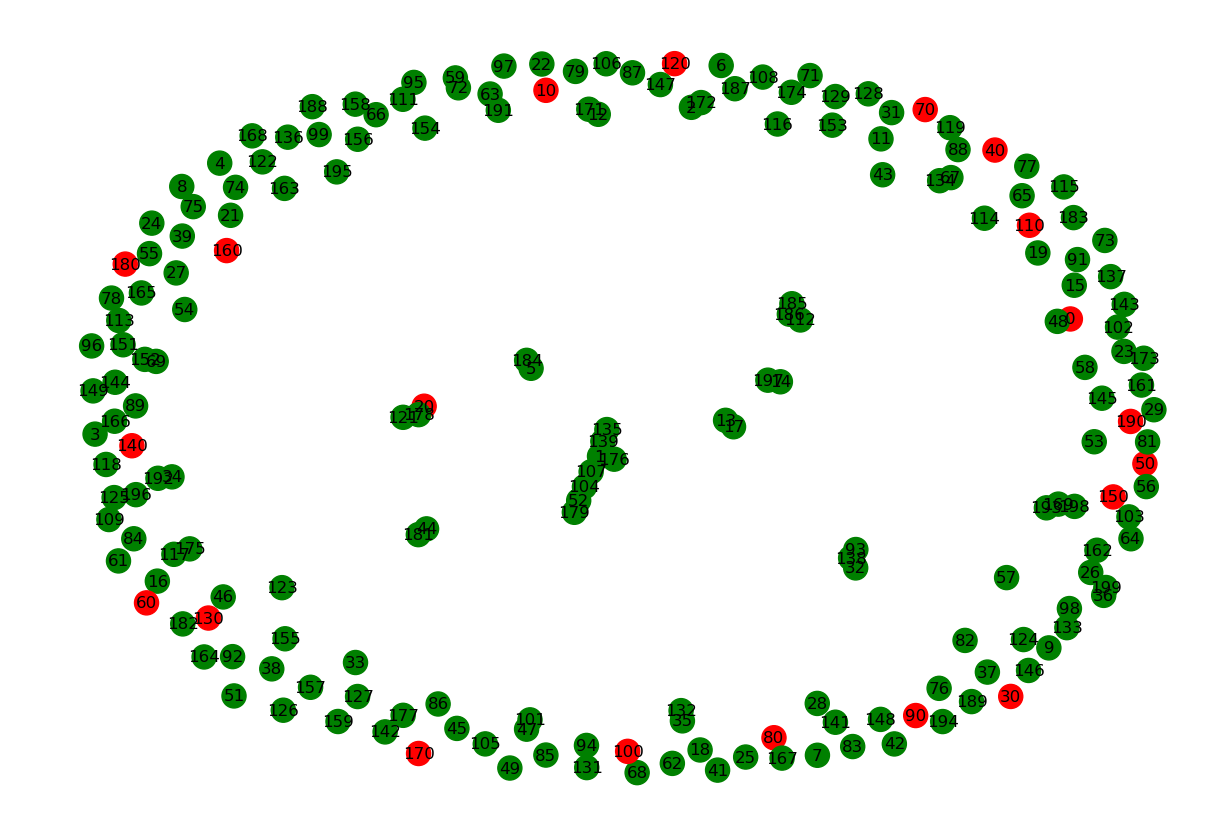

Spectral Radius: 1.989043790736546


In [4]:
import pandas as pd
import random
import os
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_remaining_self_loops
import torch.nn.functional as F
import time
from sklearn.preprocessing import StandardScaler
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Check current working directory
print(f"Current working directory: {os.getcwd()}")

# Function to generate random IP addresses
def generate_random_ip():
    return f"{random.randint(1, 255)}.{random.randint(1, 255)}.{random.randint(1, 255)}.{random.randint(1, 255)}"

# Protocol types
protocols = ['Modbus', 'Profibus', 'Profinet']

# Create synthetic nodes
num_nodes = 200  # Number of synthetic nodes
nodes_df = pd.DataFrame({
    'Id': range(num_nodes),
    'Label': ['Anomalous' if i % 10 == 0 else 'Normal' for i in range(num_nodes)],
    'src_ip': [generate_random_ip() for _ in range(num_nodes)],
    'dest_ip': [generate_random_ip() for _ in range(num_nodes)],
    'protocol': [random.choice(protocols) for _ in range(num_nodes)]
})

# Save synthetic nodes data to CSV
nodes_df.to_csv('synthetic_nodes.csv', index=False)

# Output to verify
print("Synthetic Nodes Data:")
print(nodes_df.head(15))  # Display more rows to show mix

# Load edges data from ICS example
ics_edges_df = pd.read_csv('ICS_OT Edges.csv')

# Generate synthetic edges based on the ICS topology
synthetic_edges = []
for i in range(len(ics_edges_df)):
    src = random.randint(0, num_nodes - 1)
    dest = random.randint(0, num_nodes - 1)
    while src == dest:  # Ensure no self-loops
        dest = random.randint(0, num_nodes - 1)
    synthetic_edges.append([src, dest])

# Add synthetic edges to edges DataFrame
edges_df = pd.DataFrame(synthetic_edges, columns=['Source', 'Target'])

# Save synthetic edges data to CSV
edges_df.to_csv('synthetic_edges.csv', index=False)

# Output to verify
print("Synthetic Edges Data:")
print(edges_df.head(15))

# Function to convert IPs to numerical values
def ip_to_int(ip):
    return int(''.join(f'{int(x):02X}' for x in ip.split('.')), 16)

# Function to prepare data for training
def prepare_data(nodes_df, edges_df):
    nodes_df['src_ip'] = nodes_df['src_ip'].apply(ip_to_int)
    nodes_df['dest_ip'] = nodes_df['dest_ip'].apply(ip_to_int)

    protocol_mapping = {protocol: i for i, protocol in enumerate(protocols)}
    nodes_df['protocol'] = nodes_df['protocol'].map(protocol_mapping)

    # Check for NaNs after conversion
    print("Checking for NaNs in node features after conversion:")
    print(nodes_df[['src_ip', 'dest_ip', 'protocol']].isna().sum())

    # Feature scaling
    scaler = StandardScaler()
    x = scaler.fit_transform(nodes_df[['src_ip', 'dest_ip', 'protocol']].values)
    x = torch.tensor(x, dtype=torch.float32)

    edge_index = torch.tensor(edges_df[['Source', 'Target']].values.T, dtype=torch.long)
    edge_weight = torch.tensor(edges_df['Weight'].fillna(1.0).values if 'Weight' in edges_df.columns else [1.0]*len(edges_df), dtype=torch.float32)  # Fill NaNs in weights with 1.0

    valid_edges_mask = (edge_index[0] < len(nodes_df)) & (edge_index[1] < len(nodes_df))
    edge_index = edge_index[:, valid_edges_mask]
    edge_weight = edge_weight[valid_edges_mask]

    edge_index, edge_weight = add_remaining_self_loops(edge_index, edge_weight, fill_value=1, num_nodes=len(nodes_df))

    labels = torch.tensor([0 if label == 'Normal' else 1 for label in nodes_df['Label']], dtype=torch.long)

    data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight, y=labels)
    return data

# Load synthetic data
nodes_df = pd.read_csv('synthetic_nodes.csv')
edges_df = pd.read_csv('synthetic_edges.csv')
data = prepare_data(nodes_df, edges_df)

# Split into training and validation sets
train_mask = torch.zeros(len(nodes_df), dtype=torch.bool)
val_mask = torch.zeros(len(nodes_df), dtype=torch.bool)

train_indices = list(range(0, len(nodes_df), 2))
val_indices = list(range(1, len(nodes_df), 2))

train_mask[train_indices] = True
val_mask[val_indices] = True

data.train_mask = train_mask
data.val_mask = val_mask

# Define the GCN model using spectral convolutions
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)  # Add another hidden layer
        self.conv3 = GCNConv(hidden_channels, out_channels)  # Output layer
        self.dropout = torch.nn.Dropout(p=0.5)  # Add dropout
        
    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.conv2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.conv3(x, edge_index, edge_weight)
        return F.log_softmax(x, dim=1)

# Check for MPS availability and set the device accordingly
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

model = GCN(in_channels=3, hidden_channels=8, out_channels=2).to(device)  # Increase hidden layer size

# Set up the optimizer and loss function with class weights
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
class_weights = torch.tensor([1.0, 3.0], dtype=torch.float32).to(device)  # Adjust weights as needed
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Record the start time
start_time = time.time()

data = data.to(device)
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Record the end time
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Training completed in {elapsed_time:.2f} seconds')

# Save the trained model to a file
torch.save(model.state_dict(), 'gcn_ics_model.pth')
print("Model saved to 'gcn_ics_model.pth'")

# Evaluate on validation set
model.eval()
with torch.no_grad():
    out = model(data)
    val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
    _, pred = out.max(dim=1)
    correct = pred[data.val_mask].eq(data.y[data.val_mask]).sum().item()
    accuracy = correct / data.val_mask.sum().item()
    print(f'Validation Loss: {val_loss.item()}, Accuracy: {accuracy:.4f}')

# Detect anomalies in validation set
anomalies = (pred[data.val_mask] == 1).nonzero(as_tuple=True)[0]
print(f"Anomalous nodes in validation set: {anomalies}")

if len(anomalies) > 0:
    print("Anomalies detected! Investigate the following nodes:")
    anomalous_node_ids = []
    for node in anomalies:
        node_id = int(node.item())  # Convert tensor to integer
        node_label = data.y[node_id].item()  # Get the label for verification
        print(f"Node ID: {nodes_df.iloc[node_id]['Id']}, Original Label: {nodes_df.iloc[node_id]['Label']}, Predicted Label: {'Anomalous' if node_label == 1 else 'Normal'}")
        anomalous_node_ids.append(node_id)

# Debug: List all nodes and their labels
print("All nodes and their labels:")
for i, row in nodes_df.iterrows():
    print(f"Node ID: {row['Id']}, Label: {row['Label']}")

# Visualize the network structure
G = nx.Graph()
for _, row in nodes_df.iterrows():
    G.add_node(row['Id'], label=row['Label'])
for _, row in edges_df.iterrows():
    G.add_edge(row['Source'], row['Target'])

pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))
node_colors = ['red' if nodes_df.loc[n, 'Label'] == 'Anomalous' else 'green' for n in G.nodes]
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='blue')
plt.show()

# Calculate the spectral radius
adj_matrix = nx.adjacency_matrix(G).todense()
eigenvalues = np.linalg.eigvals(adj_matrix)
spectral_radius = np.max(np.abs(eigenvalues))

print(f"Spectral Radius: {spectral_radius}")
